In [1]:
img_paths = "/content/drive/MyDrive/DL2023p-licd/S06/Actividad 6/data/images"
annotations_path = "/content/drive/MyDrive/DL2023p-licd/S06/Actividad 6/data/airplanes.csv"

import os
import random
import cv2 as cv

import tensorflow as tf
from tensorflow import keras
from tensorflow.data import AUTOTUNE

from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [2]:
import tensorflow as tf
LReLU=tf.keras.layers.LeakyReLU()

In [3]:
def preprocess_bbox(img_src, annotation):
  filename, x_min, y_min, x_max, y_max = annotation.split(",")
  img_path = img_src + "/" + filename
  img = cv.imread(img_path)
  h, w, _ = img.shape
  annotation="".join([img_path, ",", str(float(x_min)/w), ",",
                   str(float(y_min)/h), ",",
                   str(float(x_max)/w), ",",
                   str(float(y_max)/h)])
  return annotation

In [4]:
txt=preprocess_bbox("/content/drive/MyDrive/DL2023p-licd/S06/Actividad 6/data/images", "image_0720.jpg,50,31,352,118")
print(txt)

/content/drive/MyDrive/DL2023p-licd/S06/Actividad 6/data/images/image_0720.jpg,0.12376237623762376,0.2152777777777778,0.8712871287128713,0.8194444444444444


In [5]:
def build_datasets(images_path, annotations_path, train_split=0.9, val_split=0.1):
  
  examples = []
  
  annotations = open(annotations_path).read().splitlines()
  
  examples = [preprocess_bbox(images_path, item) for item in annotations]

  # Generar un indice aleatorio
  random.shuffle(examples)

  # Splits sobre el indice de los dataset: training y test
  s = int(len(examples)*train_split)
  train_examples = examples[:s]
  test_examples = examples[s:]

  # Splits sobre train_index para obtener los indieces de: train y test
  s = int(len(train_examples)*val_split)
  val_examples = train_examples[:s]
  train_examples = train_examples[s:]

  return train_examples, val_examples, test_examples

In [6]:
train_data, val_data, test_data = build_datasets(img_paths, annotations_path, 0.95, 0.1)

In [7]:
print(train_data[0])

/content/drive/MyDrive/DL2023p-licd/S06/Actividad 6/data/images/image_0391.jpg,0.14148681055155876,0.23076923076923078,0.8633093525179856,0.7972027972027972


In [8]:
import sys

def loadExample(example):

  #Extrar información de la cadena de texto
  # image_path y bbox
  str_tensors = tf.strings.split(example, sep=",")

  #Cargar imagen
  img = tf.io.read_file(str_tensors[0])
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, dtype=tf.float16)
  img = tf.image.resize(img, (128, 128))

  x_min=tf.strings.to_number(str_tensors[1])
  y_min=tf.strings.to_number(str_tensors[2])
  x_max=tf.strings.to_number(str_tensors[3])
  y_max=tf.strings.to_number(str_tensors[4])

  #Salida esperada
  label = [x_min, y_min, x_max, y_max]

  return (img, label)

In [9]:
img, label = loadExample(train_data[0])

In [10]:
print(type(train_data))

<class 'list'>


In [11]:
# Datasets

bath_size=32
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = (train_dataset
                 .shuffle(len(train_data))
                 .map(loadExample, num_parallel_calls=AUTOTUNE)
                 .cache()
                 .batch(bath_size)
                 .prefetch(AUTOTUNE)
                 )

val_dataset = tf.data.Dataset.from_tensor_slices(val_data)
val_dataset = (val_dataset
                 .shuffle(len(val_data))
                 .map(loadExample, num_parallel_calls = AUTOTUNE)
                 .cache()
                 .batch(bath_size)
                 .prefetch(AUTOTUNE)
                 )

In [12]:
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(128,128, 3)))
vgg.trainable=True
output_vgg = vgg.output
x = Flatten()(output_vgg)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
output_tensor = Dense(4)(x)

58889256/58889256 [==============================] - 2s 0us/step


In [13]:
modelB = Model(inputs=vgg.input, outputs=output_tensor)

In [14]:
def GIoU(bbox_true, bbox_pred):

  zero = tf.convert_to_tensor(0.0, bbox_true.dtype)
  Ax1, Ay1, Ax2, Ay2 = tf.unstack(bbox_true, 4, axis=-1)
  Bx1, By1, Bx2, By2 = tf.unstack(bbox_pred, 4, axis=-1)

  # Para el bounding box predicho: asegurar que Bx2 > Bx1 y By2 > By1
  bx1 = tf.math.minimum(Bx1, Bx2)
  by1 = tf.math.minimum(By1, By2)
  bx2 = tf.math.maximum(Bx1, Bx2)
  by2 = tf.math.maximum(By1, By2)
  
  #Calcular el área del bounding box verdadero
  A_area = (Ax2-Ax1)*(Ay2-Ay1)
  
  #Calcular el área del bounding box predicho  
  B_area = (bx2-bx1)*(by2-by1)
  
  #Calcular la intersección entre los bounding box A y B
  x_inter_1 = tf.math.maximum(bx1, Ax1) 
  y_inter_1 = tf.math.maximum(by1, Ay1)
  x_inter_2 = tf.math.minimum(bx2, Ax2) 
  y_inter_2 = tf.math.minimum(by2, Ay2)

  w_inter = tf.maximum(zero, x_inter_1 - x_inter_2)
  h_inter = tf.maximum(zero, y_inter_1 - y_inter_2)  

  I = w_inter * h_inter

  area_union = (B_area + A_area) - I
  iou = tf.math.divide_no_nan(I, area_union)

  #Encontrar el Bbox C más pequeño que abarque a los bboxes A y B
  Cx1 = tf.math.minimum(bx1, Ax1)
  Cy1 = tf.math.minimum(by1, Ay1)
  Cx2 = tf.math.maximum(bx2, Ax2)
  Cy2 = tf.math.maximum(by2, Ay2)

  #Calcular el área del bbox C  
  C_area = (Cx2-Cx1) * (Cy2-Cy1)

  giou = iou - tf.math.divide_no_nan(C_area-area_union, C_area)
  m_giou = tf.reduce_mean(giou,axis=0)
  return m_giou

In [15]:
def GIoU_loss(bbox_true, bbox_pred):
  return 1.0 - GIoU(bbox_true, bbox_pred)

In [16]:
boxes1 = tf.constant([[4.0/32.0, 3.0/32.0, 7.0/32.0, 5.0/32.0], [5.0/32.0, 6.0/32.0, 10.0/32.0, 7.0/32.0]])
boxes2 = tf.constant([[3.0/32.0, 4.0/32.0, 6.0/32.0, 8.0/32.0], [14.0/32.0, 14.0/32.0, 15.0/32.0, 15.0/32.0]])

res=GIoU(boxes1, boxes2)
res_l=GIoU_loss(boxes1, boxes2)

In [17]:
print(res_l)
print(res)

tf.Tensor(2.308586, shape=(), dtype=float32)
tf.Tensor(-1.3085859, shape=(), dtype=float32)


In [18]:
from tensorflow.keras.optimizers import Adam

opt=Adam(learning_rate=1e-4)
modelB.compile(loss=GIoU_loss, optimizer=opt, metrics=GIoU)

In [19]:
log = modelB.fit(train_dataset,
                 validation_data = val_dataset,
                 epochs=25, 
                 verbose=1)

Epoch 1/25
22/22 [==============================] - 30s 282ms/step - loss: 0.3604 - GIoU: 0.6467 - val_loss: 0.1517 - val_GIoU: 0.8471
Epoch 2/25
22/22 [==============================] - 3s 144ms/step - loss: 0.1244 - GIoU: 0.8764 - val_loss: 0.1484 - val_GIoU: 0.8515
Epoch 3/25
22/22 [==============================] - 3s 144ms/step - loss: 0.1250 - GIoU: 0.8758 - val_loss: 0.1303 - val_GIoU: 0.8714
Epoch 4/25
22/22 [==============================] - 3s 144ms/step - loss: 0.1159 - GIoU: 0.8850 - val_loss: 0.1007 - val_GIoU: 0.8994
Epoch 5/25
22/22 [==============================] - 3s 149ms/step - loss: 0.1004 - GIoU: 0.9002 - val_loss: 0.1179 - val_GIoU: 0.8817
Epoch 6/25
22/22 [==============================] - 3s 144ms/step - loss: 0.1087 - GIoU: 0.8914 - val_loss: 0.1252 - val_GIoU: 0.8738
Epoch 7/25
22/22 [==============================] - 3s 144ms/step - loss: 0.1103 - GIoU: 0.8903 - val_loss: 0.1153 - val_GIoU: 0.8848
Epoch 8/25
22/22 [==============================] - 3s 147ms/

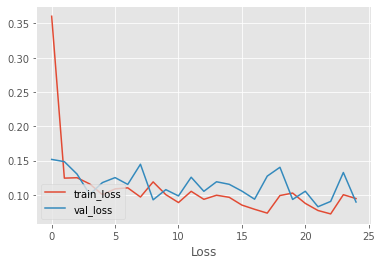

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import imutils
# Número de épocas
N = 25
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), log.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), log.history["val_loss"], label="val_loss")
plt.xlabel("Epochs #")
plt.xlabel("Loss")
plt.legend(loc = "lower left")
plt.savefig("plot.png")

In [21]:
m=12
#x_test, y_test = loadExample(train_data[m])
x_test, y_test = loadExample(test_data[m])

In [22]:
print(x_test.shape)
m_x_test = tf.expand_dims(x_test, 0)
print(m_x_test.shape)

(128, 128, 3)
(1, 128, 128, 3)


In [23]:
(Xmin, Ymin, Xmax, Ymax) = y_test
print(Xmin.numpy(), Ymin.numpy(), Xmax.numpy(), Ymax.numpy())

Yp = modelB.predict(m_x_test)[0]
(Xminp, Yminp, Xmaxp, Ymaxp) = Yp
print(Xminp, Yminp, Xmaxp, Ymaxp)

0.13197969 0.1693989 0.8527919 0.84153
1/1 [==============================] - 1s 858ms/step
0.13450846 0.8168816 0.86185503 0.16681553


40 113 258 23


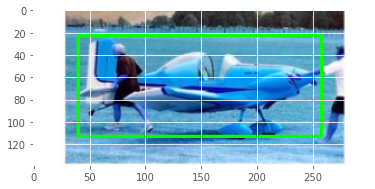

In [24]:
path=test_data[m].split(",")[0]
img = cv.imread(path)
img = imutils.resize(img, width=300)
h, w = img.shape[:2]

Xminp=int(Xminp * w)
Yminp=int(Yminp * h)
Xmaxp=int(Xmaxp * w)
Ymaxp=int(Ymaxp * h)

print(Xminp, Yminp, Xmaxp, Ymaxp)

img= cv.rectangle(img, (Xminp, Yminp), (Xmaxp, Ymaxp), (0, 255, 0), 2)
#plt.axis("off")
plt.imshow(img)
plt.show()